In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder

data1 = pd.read_csv("UCI_dataset_norm.csv", header = None, index_col = 0).reset_index()
data2 = pd.read_csv("market-basket-optimization_norm.csv", header = 0, index_col = 0).reset_index()
data3 = pd.read_csv("order_products__train_norm.csv", header = 0, index_col = 0).reset_index()

print(data1.shape)
print(data2.shape)
print(data3.shape)

data1 = data1.bfill(axis=1).ffill(axis=1)
data2 = data2.bfill(axis=1).ffill(axis=1)
data3 = data3.bfill(axis=1).ffill(axis=1)

#string for eclat
data1 = data1.applymap(int)
data2 = data2.applymap(int)
data3 = data3.applymap(int)

data1 = data1.applymap(str)
data2 = data2.applymap(str)
data3 = data3.applymap(str)
#print(data1)

print(data1)

#list of list for apriori
l_data1 = data1.values.tolist()
l_data2 = data2.values.tolist()
l_data3 = data3.values.tolist()

#te for mlxtend
te = TransactionEncoder()
te_ary = te.fit(l_data1).transform(l_data1)
te_data1 = pd.DataFrame(te_ary, columns=te.columns_)

te_ary = te.fit(l_data2).transform(l_data2)
te_data2 = pd.DataFrame(te_ary, columns=te.columns_)

te_ary = te.fit(l_data3).transform(l_data3)
te_data3 = pd.DataFrame(te_ary, columns=te.columns_)


(25900, 20)
(9834, 20)
(131208, 20)
         0     1     2     3     4     5     6     7     8     9     10    11  \
0         2   340   456   264   242   365   865   865   865   865   865   865   
1       183   266   266   266   266   266   266   266   266   266   266   266   
2         5   358   320   217  1819  1472   675   400    68   108  2902    94   
3        18  1360  1585  1116  1116  1116  1116  1116  1116  1116  1116  1116   
4       462   462   462   462   462   462   462   462   462   462   462   462   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25895  3447  3447  3447  3447  3447  3447  3447  3447  3447  3447  3447  3447   
25896    23   438   438   438   438   438   438   438   438   438   438   438   
25897    63    63    63    63    63    63    63    63    63    63    63    63   
25898   771   771   771   771   771   771   771   771   771   771   771   771   
25899    75   383   383   383   383   383   383   383   383   383   383  

In [2]:
"""
Aлгоритм ECLAT ссылка https://habr.com/ru/company/ods/blog/353502/
Класс инициируется 3мя параметрами:
- min_supp - минимальный support  который мы рассматриваем для ItemSet. Рассчитывается как % от количества транзакций
- max_items - максимальное количество елементов в нашем ItemSet
- min_items - минимальное количество элементов ItemSet
"""
class Eclat:
    #инициализация объекта класса
    def __init__(self, min_support = 0.01, max_items = 7, min_items = 1):
        self.min_support = min_support
        self.max_items = max_items
        self.min_items = min_items
        self.item_lst = list()
        self.item_len = 0
        self.item_dict = dict()
        self.final_dict = dict()
        self.data_size = 0
    
    #создание словаря из ненулевых объектов из всех транзакций (вертикальный датасет)
    def read_data(self, dataset):
        for index, row in dataset.iterrows():
            row_wo_na = set(row[0])
            for item in row_wo_na:
                item = item.strip()
                if item in self.item_dict:
                    self.item_dict[item][0] += 1
                else:
                    self.item_dict.setdefault(item, []).append(1)
                self.item_dict[item].append(index)
        #задаем переменные экземпляра (instance variables)
        self.data_size = dataset.shape[0]
        self.item_lst = list(self.item_dict.keys())
        self.item_len = len(self.item_lst)
        self.min_support = self.min_support * self.data_size
        #print ("min_supp", self.min_support)
        
    #рекурсивный метод для поиска всех ItemSet по алгоритму Eclat
    #структура данных: {Item: [Supp number, tid1, tid2, tid3, ...]}
    def recur_eclat(self, item_name, tids_array, minsupp, num_items, k_start):
        if tids_array[0] >= minsupp and num_items <= self.max_items:
            for k in range(k_start+1, self.item_len):
                if self.item_dict[self.item_lst[k]][0] >= minsupp:
                    new_item = item_name + " | " + self.item_lst[k]
                    new_tids = np.intersect1d(tids_array[1:], self.item_dict[self.item_lst[k]][1:])
                    new_tids_size = new_tids.size
                    new_tids = np.insert(new_tids, 0, new_tids_size)
                    if new_tids_size >= minsupp:
                        if num_items >= self.min_items: self.final_dict.update({new_item: new_tids})
                        self.recur_eclat(new_item, new_tids, minsupp, num_items+1, k)
    
    #последовательный вызов функций определенных выше
    def fit(self, dataset):
        i = 0
        self.read_data(dataset)
        for w in self.item_lst:
            self.recur_eclat(w, self.item_dict[w], self.min_support, 2, i)
            i+=1
        return self
        
    #вывод в форме словаря {ItemSet: support(ItemSet)}
    def transform(self):
        d = {k: "{0:.4f}".format((v[0]+0.0)/self.data_size) for k, v in self.final_dict.items()}
        return pd.DataFrame(d.items(), columns=['itemsets', 'support']) 

In [3]:
#Функции, для которых будем вычислять время выполнения
import sys
from timeit import Timer

from mlxtend.frequent_patterns import apriori
import apyori
from mlxtend.frequent_patterns import fpgrowth
from pyECLAT import ECLAT

def apriori_execute(df, min_support):
    return apriori(df, min_support=min_support, max_len=7, use_colnames=True)

def apyori_execute(df, min_support):
    return apyori.apriori(df, min_support = min_support, min_confidence = 0.0, max_length = 7)

def fpgrowth_execute(df, min_support):
    return fpgrowth(df, min_support=min_support, use_colnames=True)

def pyeclat_execute(df, min_support):
    eclat_instance = ECLAT(data=df, verbose=True)
    get_ECLAT_indexes, get_ECLAT_supports = eclat_instance.fit(min_support=min_support, verbose=False)
    return get_ECLAT_supports

def eclat_execute(df, min_support):
    eclat = Eclat(min_support = min_support, max_items = 7, min_items = 1)
    result_dict = eclat.fit(df).transform()
    return result_dict

In [4]:
import shutil, os 
from io import StringIO
import json #преобразовывать будем в json, используя встроенные в модуль методы
pd.options.display.expand_frame_repr = False
from collections import OrderedDict

def json_to_df(result):
    result = list(result)
    output = []
    for RelationRecord in result:
        o = StringIO()
        apyori.dump_as_json(RelationRecord, o)
        output.append(json.loads(o.getvalue()))
    return pd.DataFrame(output, columns = ['items', 'support', 'ordered_statistics'])

def dataset_transform(dataset, func):
    result = pd.DataFrame(columns = ['support', 'itemsets', 'len'])
    #преобразовать датафреймы к единому виду support - itemset (tuple) - len of itemset
    if func == apriori_execute:
        result['support'] = dataset['support']
        result['itemsets'] = dataset['itemsets'].apply(lambda x: tuple(x))
    if func == apyori_execute:
        #print(dataset.columns[0])
        result['support'] = dataset['support']
        result['itemsets'] = dataset['items'].apply(lambda x: tuple(x))
    if func == fpgrowth_execute:
        result['support'] = dataset['support']
        result['itemsets'] = dataset['itemsets'].apply(lambda x: tuple(x))
    if func == eclat_execute:
        result['support'] = dataset['support']
        result['itemsets'] = dataset['itemsets'].apply(lambda x: tuple(map(str.strip, x.split('|'))))
    result['len'] = result['itemsets'].apply(lambda x: len(x))
    return result
                
    
funcs = [apriori_execute, apyori_execute, fpgrowth_execute, eclat_execute] #, pyeclat_execute]
dataframes1 = [te_data1, l_data1, te_data1, data1] 
dataframes2 = [te_data2, l_data2, te_data2, data2]
dataframes3 = [te_data3, l_data3, te_data3, data3]
coll_df = [dataframes1, dataframes2, dataframes3]
name_df = ['UCI_dataset', 'market-basket-optimization', 'Instacart Market Basket Analysis']
loops = 10
supports = [0.20, 0.15, 0.10, 0.05, 0.03, 0.01]
table = []
results = []
tables = []
reports = []
for n, coll in enumerate(coll_df):
    for supp in supports:
        print(f"Рассчитывается порог поддержки: {supp*100} %")
        for i, func in enumerate(funcs): 
            param = (coll[i], supp)
            print("Start " + func.__name__)
            t = Timer(lambda: func(param[0], param[1]))
            time = t.timeit(number = loops)
            result = func(param[0], param[1])
            
            if func == apyori_execute: #convert list to dataframe
                result = json_to_df(result)
            result = dataset_transform(result, func)
            
            #сортировка датасета по убыванию поддержки
            result.sort_values(['support'], ascending = False, inplace = True)
            
            results.append(result)
            
            #получаем кол-во наборов различной длины
            index_series = result['len'].value_counts().index.tolist()
            count_different_len = pd.Series(index = index_series, dtype = 'Int32')
            for index in index_series:
                count_different_len[index] = result['len'].eq(index).sum() #подсчет числа вхождений
                
            table.append([func.__name__, supp, time, result.shape[0], result['len'].max(), count_different_len.to_dict(OrderedDict)])
    pd_table = pd.DataFrame(table, columns = ['name', 'support', 'time', 'rows_count', 'max_len', 'count_different_len'])
    tables.append(pd_table)        
    print(f"\nНабор данных {name_df[n]}: сводная таблица времени выполнения")
    print(pd_table)

    #Вывод данных
    HEAD = 5
    for i, result in enumerate(results):
        print(f'Алгоритм {table[i][0]}, поддержка {table[i][1]}, количество строк результата - {result.shape[0]}')
        print(f'Первые {HEAD} строк результата c наибольшей поддержкой:')
        print(result.head(HEAD))
        print('\n')
    reports.append(results)
    results = []
    table = []

Рассчитывается порог поддержки: 20.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 15.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 10.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 5.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 3.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 1.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute

Набор данных UCI_dataset: сводная таблица времени выполнения
                name  support        time  rows_count  max_len    count_different_len
0    apriori_execute     0.20    1.793529           0      NaN                     {}
1     apyori_execut

Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 15.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 10.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 5.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 3.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 1.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute

Набор данных market-basket-optimization: сводная таблица времени выполнения
                name  support       time  rows_count  max_len     count_different_len
0    apriori_execute     0.20   0.069779           1      1.0                  {1: 1}
1     apyori_execute     0.20   0.000014           1      1.0                  {1: 1}


Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 15.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 10.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 5.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 3.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute
Рассчитывается порог поддержки: 1.0 %
Start apriori_execute
Start apyori_execute
Start fpgrowth_execute
Start eclat_execute

Набор данных Instacart Market Basket Analysis: сводная таблица времени выполнения
                name  support        time  rows_count  max_len     count_different_len
0    apriori_execute     0.20   76.873656           0      NaN                      {}
1     apyori_execute     0.20    0.000016           0    

In [5]:
#Построение графиков. В tables лежит список (по датасетам) таблиц с временем выполнения; 
#в reports лежит список (по датасетам) списков датафреймов с результатами работы алгоритмов.


сравнение быстродействия apriori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    231.134767
0.03      2.174578
0.05      1.661577
0.10      1.622675
0.15      1.816421
0.20      1.793529
Name: time, dtype: float64


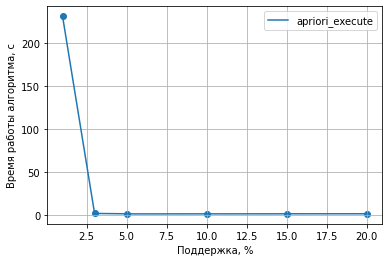

сравнение быстродействия apyori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    0.000017
0.03    0.000014
0.05    0.000014
0.10    0.000013
0.15    0.000016
0.20    0.000016
Name: time, dtype: float64


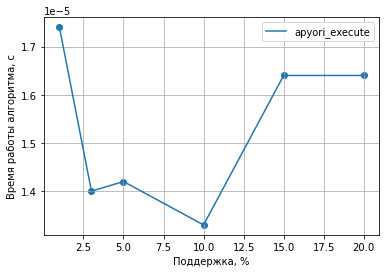

сравнение быстродействия fpgrowth_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    10.434879
0.03     5.036532
0.05     4.614114
0.10     4.505783
0.15     4.759325
0.20     4.658317
Name: time, dtype: float64


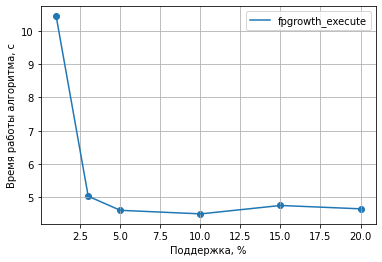

сравнение быстродействия eclat_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    36.465714
0.03    34.572456
0.05    33.205877
0.10    34.751094
0.15    34.846475
0.20    35.253209
Name: time, dtype: float64


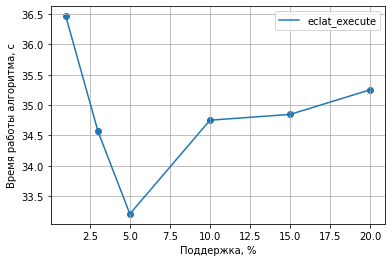

сравнение быстродействия apriori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    5.729199
0.03    1.019785
0.05    0.391499
0.10    0.093123
0.15    0.072403
0.20    0.069779
Name: time, dtype: float64


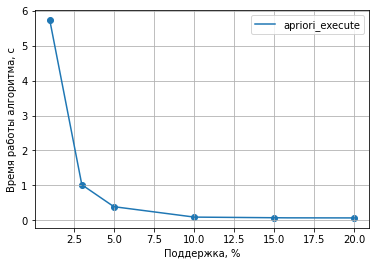

сравнение быстродействия apyori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    0.000015
0.03    0.000017
0.05    0.000016
0.10    0.000014
0.15    0.000014
0.20    0.000014
Name: time, dtype: float64


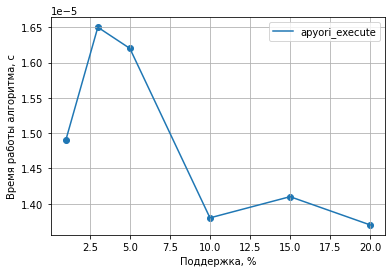

сравнение быстродействия fpgrowth_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    3.087898
0.03    2.080632
0.05    1.768760
0.10    0.997608
0.15    0.925393
0.20    0.904365
Name: time, dtype: float64


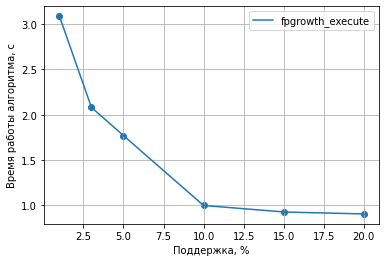

сравнение быстродействия eclat_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    11.920142
0.03    11.739406
0.05    13.225267
0.10    11.658735
0.15    11.528947
0.20    11.331937
Name: time, dtype: float64


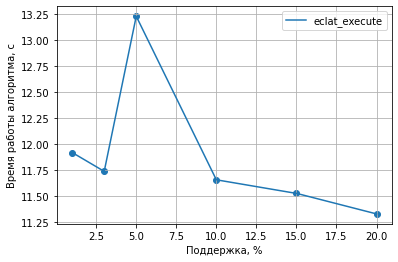

сравнение быстродействия apriori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    515.483933
0.03     85.561448
0.05     76.781623
0.10     79.861944
0.15     75.755357
0.20     76.873656
Name: time, dtype: float64


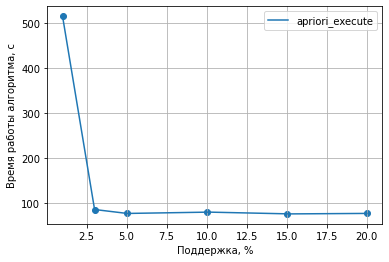

сравнение быстродействия apyori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    0.000014
0.03    0.000014
0.05    0.000014
0.10    0.000014
0.15    0.000020
0.20    0.000016
Name: time, dtype: float64


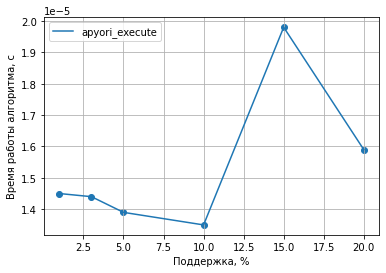

сравнение быстродействия fpgrowth_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    138.177787
0.03    124.134246
0.05    120.728434
0.10    121.134198
0.15    120.404326
0.20    119.590685
Name: time, dtype: float64


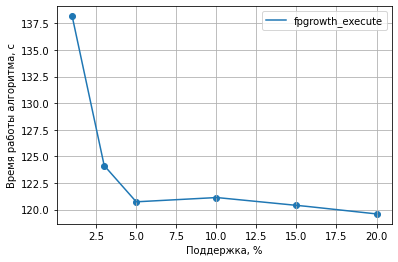

сравнение быстродействия eclat_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    202.242638
0.03    196.525663
0.05    186.119948
0.10    178.560065
0.15    171.520954
0.20    166.955985
Name: time, dtype: float64


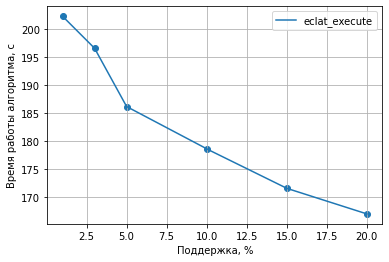

In [6]:
#сравнение быстродействия алгоритмов на фиксированном наборе данных при изменяемом пороге поддержки; 

import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

for i, table in enumerate(tables):
    for algorithm_number in range(len(funcs)):
        table1 = table.groupby(['support']).nth(algorithm_number)
        print(f"сравнение быстродействия {table1['name'].iloc[0]} на датасете {name_df[i]} при изменяемом пороге поддержки")
        print(table1['time'])
        
        x = table1.index * 100
        y = table1['time']
        x_new = np.linspace(x.min(), x.max(),500)

        f = interp1d(x, y, kind='linear')
        y_smooth=f(x_new)
        
        fig, ax = plt.subplots()
        ax.grid()
        ax.set_xlabel('Поддержка, %')
        ax.set_ylabel('Время работы алгоритма, с')
       
        ax.plot (x_new,y_smooth, label = table1['name'].iloc[0])
        ax.scatter (x, y) 
        ax.legend()
        plt.show()

общее кол-во частых наборов apriori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    236
0.03     10
0.05      2
0.10      0
0.15      0
0.20      0
Name: rows_count, dtype: int64


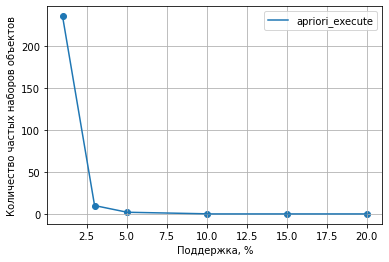

общее кол-во частых наборов apyori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    236
0.03     10
0.05      2
0.10      0
0.15      0
0.20      0
Name: rows_count, dtype: int64


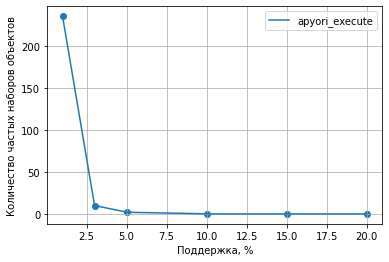

общее кол-во частых наборов fpgrowth_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    236
0.03     10
0.05      2
0.10      0
0.15      0
0.20      0
Name: rows_count, dtype: int64


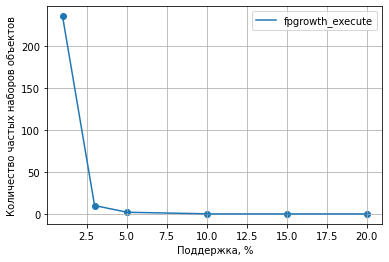

общее кол-во частых наборов eclat_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    87
0.03    45
0.05    22
0.10     3
0.15     0
0.20     0
Name: rows_count, dtype: int64


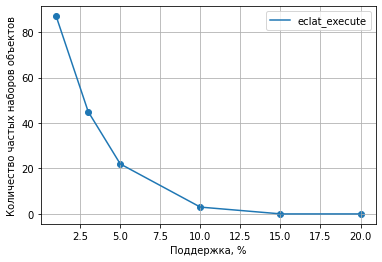

общее кол-во частых наборов apriori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    329
0.03     63
0.05     31
0.10      8
0.15      4
0.20      1
Name: rows_count, dtype: int64


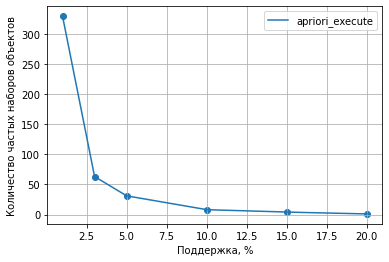

общее кол-во частых наборов apyori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    329
0.03     63
0.05     31
0.10      8
0.15      4
0.20      1
Name: rows_count, dtype: int64


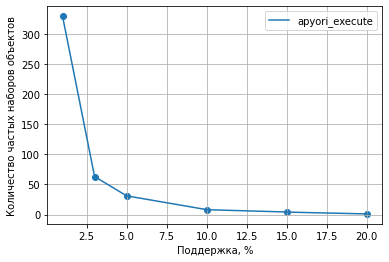

общее кол-во частых наборов fpgrowth_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    329
0.03     63
0.05     31
0.10      8
0.15      4
0.20      1
Name: rows_count, dtype: int64


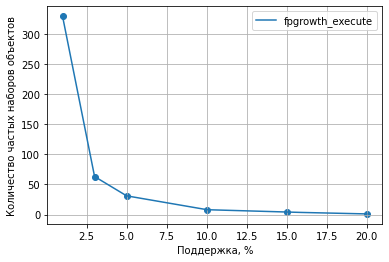

общее кол-во частых наборов eclat_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    16
0.03     7
0.05     4
0.10     1
0.15     0
0.20     0
Name: rows_count, dtype: int64


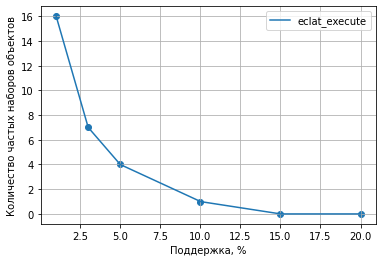

общее кол-во частых наборов apriori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    109
0.03     15
0.05      7
0.10      2
0.15      0
0.20      0
Name: rows_count, dtype: int64


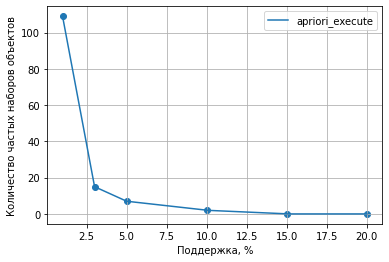

общее кол-во частых наборов apyori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    109
0.03     15
0.05      7
0.10      2
0.15      0
0.20      0
Name: rows_count, dtype: int64


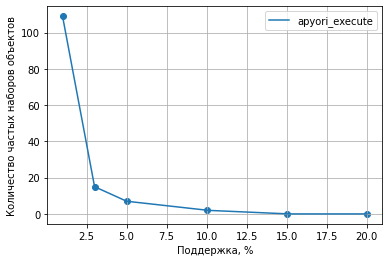

общее кол-во частых наборов fpgrowth_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    109
0.03     15
0.05      7
0.10      2
0.15      0
0.20      0
Name: rows_count, dtype: int64


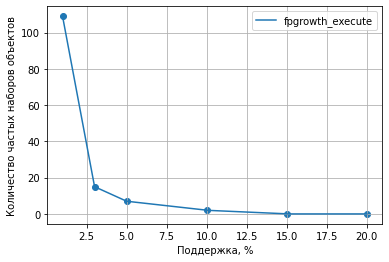

общее кол-во частых наборов eclat_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    219
0.03    131
0.05     68
0.10     34
0.15     17
0.20      2
Name: rows_count, dtype: int64


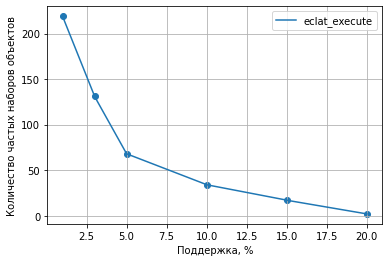

In [7]:
#общее количество частых наборов объектов на фиксированном наборе данных при изменяемом пороге поддержки; 

for i, table in enumerate(tables):
    for algorithm_number in range(len(funcs)):
        table1 = table.groupby(['support']).nth(algorithm_number)
        print(f"общее кол-во частых наборов {table1['name'].iloc[0]} на датасете {name_df[i]} при изменяемом пороге поддержки")
        print(table1['rows_count'])
        
        x = table1.index * 100
        y = table1['rows_count']
        x_new = np.linspace(x.min(), x.max(),500)

        f = interp1d(x, y, kind='linear')
        y_smooth=f(x_new)
        
        fig, ax = plt.subplots()
        ax.grid()
        ax.set_xlabel('Поддержка, %')
        ax.set_ylabel('Количество частых наборов объектов')
       
        ax.plot (x_new,y_smooth, label = table1['name'].iloc[0])
        ax.scatter (x, y) 
        ax.legend()
        plt.show()

максимальная длина частого набора apriori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    3.0
0.03    1.0
0.05    1.0
0.10    NaN
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


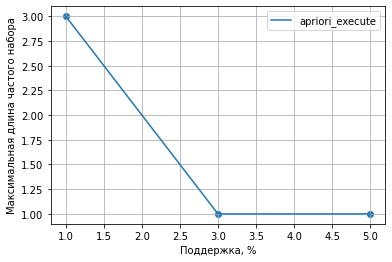

максимальная длина частого набора apyori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    3.0
0.03    1.0
0.05    1.0
0.10    NaN
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


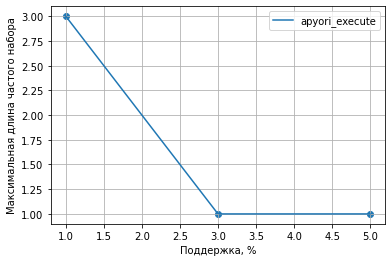

максимальная длина частого набора fpgrowth_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    3.0
0.03    1.0
0.05    1.0
0.10    NaN
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


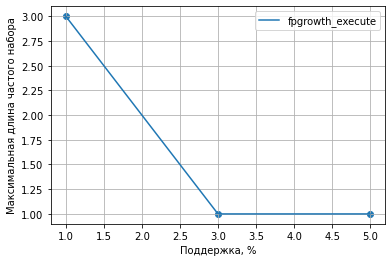

максимальная длина частого набора eclat_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    3.0
0.03    2.0
0.05    2.0
0.10    2.0
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


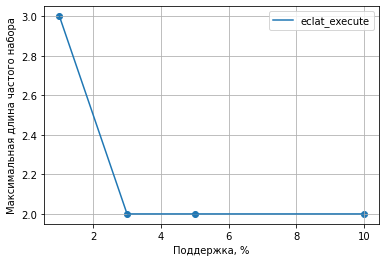

максимальная длина частого набора apriori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    3.0
0.03    2.0
0.05    2.0
0.10    1.0
0.15    1.0
0.20    1.0
Name: max_len, dtype: float64


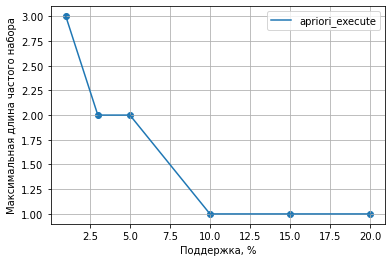

максимальная длина частого набора apyori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    3.0
0.03    2.0
0.05    2.0
0.10    1.0
0.15    1.0
0.20    1.0
Name: max_len, dtype: float64


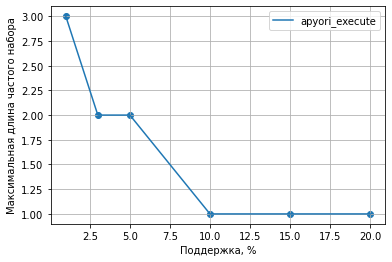

максимальная длина частого набора fpgrowth_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    3.0
0.03    2.0
0.05    2.0
0.10    1.0
0.15    1.0
0.20    1.0
Name: max_len, dtype: float64


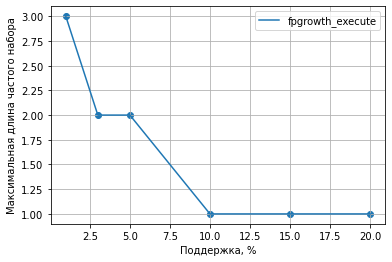

максимальная длина частого набора eclat_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    2.0
0.03    2.0
0.05    2.0
0.10    2.0
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


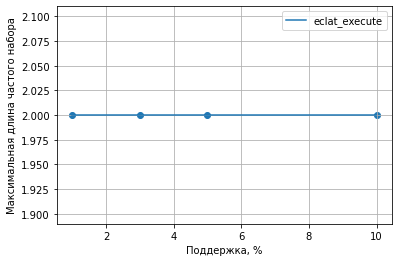

максимальная длина частого набора apriori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    2.0
0.03    1.0
0.05    1.0
0.10    1.0
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


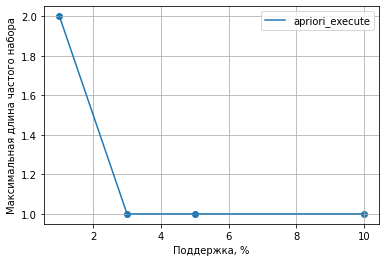

максимальная длина частого набора apyori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    2.0
0.03    1.0
0.05    1.0
0.10    1.0
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


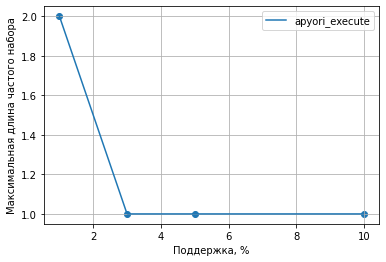

максимальная длина частого набора fpgrowth_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    2.0
0.03    1.0
0.05    1.0
0.10    1.0
0.15    NaN
0.20    NaN
Name: max_len, dtype: float64


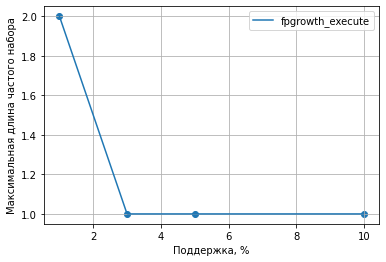

максимальная длина частого набора eclat_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    4.0
0.03    4.0
0.05    4.0
0.10    2.0
0.15    2.0
0.20    2.0
Name: max_len, dtype: float64


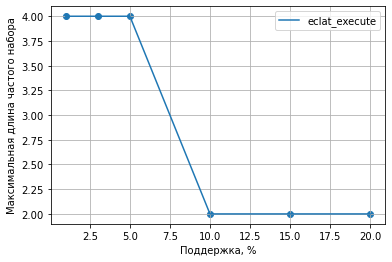

In [8]:
#максимальная длина частого набора объектов на фиксированном наборе данных при изменяемом пороге поддержки; 

for i, table in enumerate(tables):
    for algorithm_number in range(len(funcs)):
        table1 = table.groupby(['support']).nth(algorithm_number)
        print(f"максимальная длина частого набора {table1['name'].iloc[0]} на датасете {name_df[i]} при изменяемом пороге поддержки")
        print(table1['max_len'])
        
        x = table1.index * 100
        y = table1['max_len']
        x_new = np.linspace(x.min(), x.max(),500)

        f = interp1d(x, y, kind='linear')
        y_smooth=f(x_new)
        
        fig, ax = plt.subplots()
        ax.grid()
        ax.set_xlabel('Поддержка, %')
        ax.set_ylabel('Максимальная длина частого набора')
       
        ax.plot (x_new,y_smooth, label = table1['name'].iloc[0])
        ax.scatter (x, y) 
        ax.legend()
        plt.show()

количество частых наборов различной длины apriori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    {1: 215, 2: 20, 3: 1}
0.03                  {1: 10}
0.05                   {1: 2}
0.10                       {}
0.15                       {}
0.20                       {}
Name: count_different_len, dtype: object


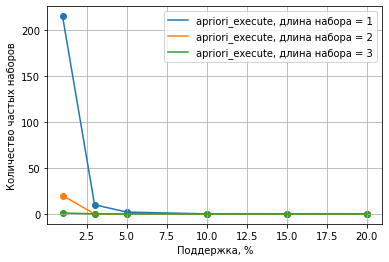

количество частых наборов различной длины apyori_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    {1: 215, 2: 20, 3: 1}
0.03                  {1: 10}
0.05                   {1: 2}
0.10                       {}
0.15                       {}
0.20                       {}
Name: count_different_len, dtype: object


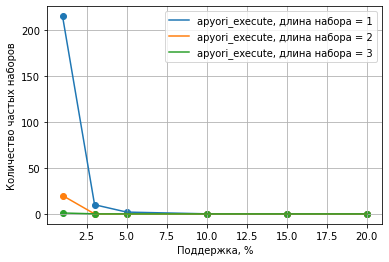

количество частых наборов различной длины fpgrowth_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    {1: 215, 2: 20, 3: 1}
0.03                  {1: 10}
0.05                   {1: 2}
0.10                       {}
0.15                       {}
0.20                       {}
Name: count_different_len, dtype: object


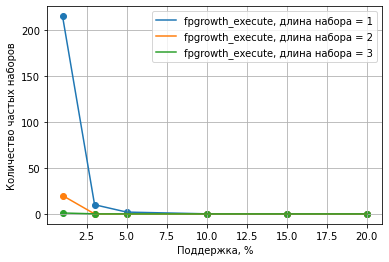

количество частых наборов различной длины eclat_execute на датасете UCI_dataset при изменяемом пороге поддержки
support
0.01    {2: 45, 3: 42}
0.03           {2: 45}
0.05           {2: 22}
0.10            {2: 3}
0.15                {}
0.20                {}
Name: count_different_len, dtype: object


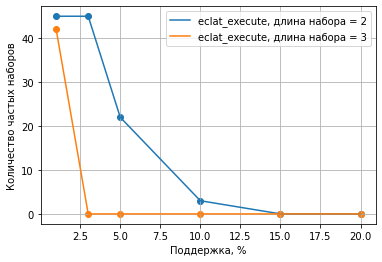

количество частых наборов различной длины apriori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    {2: 209, 1: 88, 3: 32}
0.03            {1: 44, 2: 19}
0.05             {1: 28, 2: 3}
0.10                    {1: 8}
0.15                    {1: 4}
0.20                    {1: 1}
Name: count_different_len, dtype: object


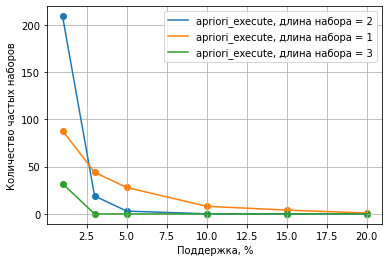

количество частых наборов различной длины apyori_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    {2: 209, 1: 88, 3: 32}
0.03            {1: 44, 2: 19}
0.05             {1: 28, 2: 3}
0.10                    {1: 8}
0.15                    {1: 4}
0.20                    {1: 1}
Name: count_different_len, dtype: object


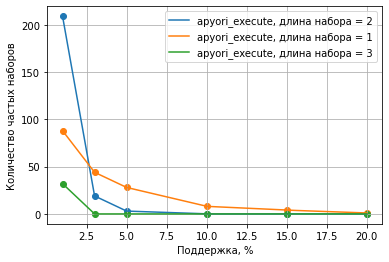

количество частых наборов различной длины fpgrowth_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    {2: 209, 1: 88, 3: 32}
0.03            {1: 44, 2: 19}
0.05             {1: 28, 2: 3}
0.10                    {1: 8}
0.15                    {1: 4}
0.20                    {1: 1}
Name: count_different_len, dtype: object


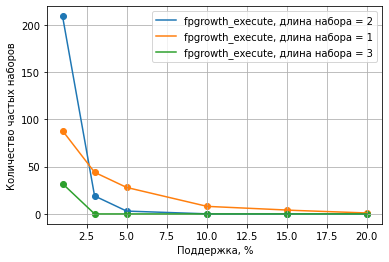

количество частых наборов различной длины eclat_execute на датасете market-basket-optimization при изменяемом пороге поддержки
support
0.01    {2: 16}
0.03     {2: 7}
0.05     {2: 4}
0.10     {2: 1}
0.15         {}
0.20         {}
Name: count_different_len, dtype: object


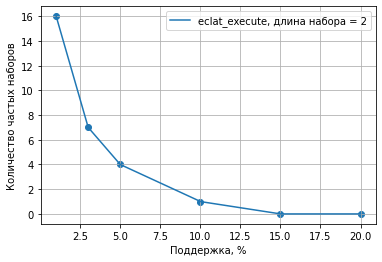

количество частых наборов различной длины apriori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    {1: 96, 2: 13}
0.03           {1: 15}
0.05            {1: 7}
0.10            {1: 2}
0.15                {}
0.20                {}
Name: count_different_len, dtype: object


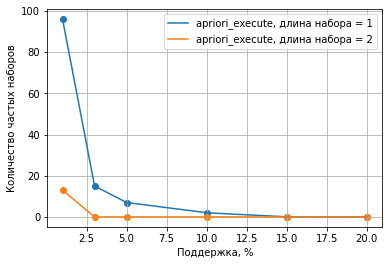

количество частых наборов различной длины apyori_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    {1: 96, 2: 13}
0.03           {1: 15}
0.05            {1: 7}
0.10            {1: 2}
0.15                {}
0.20                {}
Name: count_different_len, dtype: object


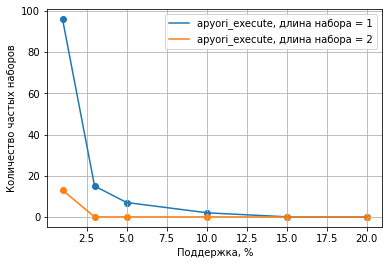

количество частых наборов различной длины fpgrowth_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    {1: 96, 2: 13}
0.03           {1: 15}
0.05            {1: 7}
0.10            {1: 2}
0.15                {}
0.20                {}
Name: count_different_len, dtype: object


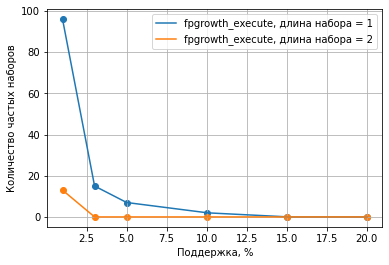

количество частых наборов различной длины eclat_execute на датасете Instacart Market Basket Analysis при изменяемом пороге поддержки
support
0.01    {3: 120, 4: 54, 2: 45}
0.03      {3: 84, 2: 45, 4: 2}
0.05      {2: 45, 3: 22, 4: 1}
0.10                   {2: 34}
0.15                   {2: 17}
0.20                    {2: 2}
Name: count_different_len, dtype: object


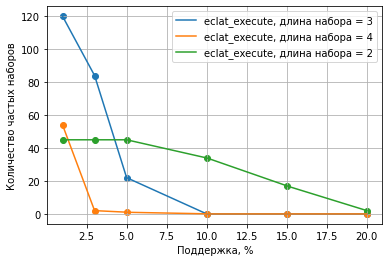

In [9]:
#количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.

for i, table in enumerate(tables):
    for algorithm_number in range(len(funcs)):
        table1 = table.groupby(['support']).nth(algorithm_number)
        print(f"количество частых наборов различной длины {table1['name'].iloc[0]} на датасете {name_df[i]} при изменяемом пороге поддержки")
        
        print(table1['count_different_len'])
        
        x = table1.index * 100
        x_new = np.linspace(x.min(), x.max(),500)
        
        keys = [] #список различных длин
        for d in table1['count_different_len']:
            for key, value in d.items():
                if key not in keys:
                    keys.append(key)
                    
        #print(keys)
        
        fig, ax = plt.subplots()
        for key in keys:
            y = []
            for d in table1['count_different_len']:
                if (key in d.keys()) and d[key] is not None:
                    y.append(d[key])
                else:
                    y.append(0)
                    
            #print(y)
            f = interp1d(x, y, kind='linear')
            y_smooth=f(x_new)
            
            ax.plot (x_new,y_smooth, label = table1['name'].iloc[0] + ', длина набора = ' + str(key))
            ax.scatter (x, y) 

        ax.grid()
        ax.set_xlabel('Поддержка, %')
        ax.set_ylabel('Количество частых наборов')
        ax.legend()
        
        plt.show()